[0]Velocity=11110.701683844512 Angle=30.193846236174522
./apollo8_data_200411_1442/apollo8_c_00/


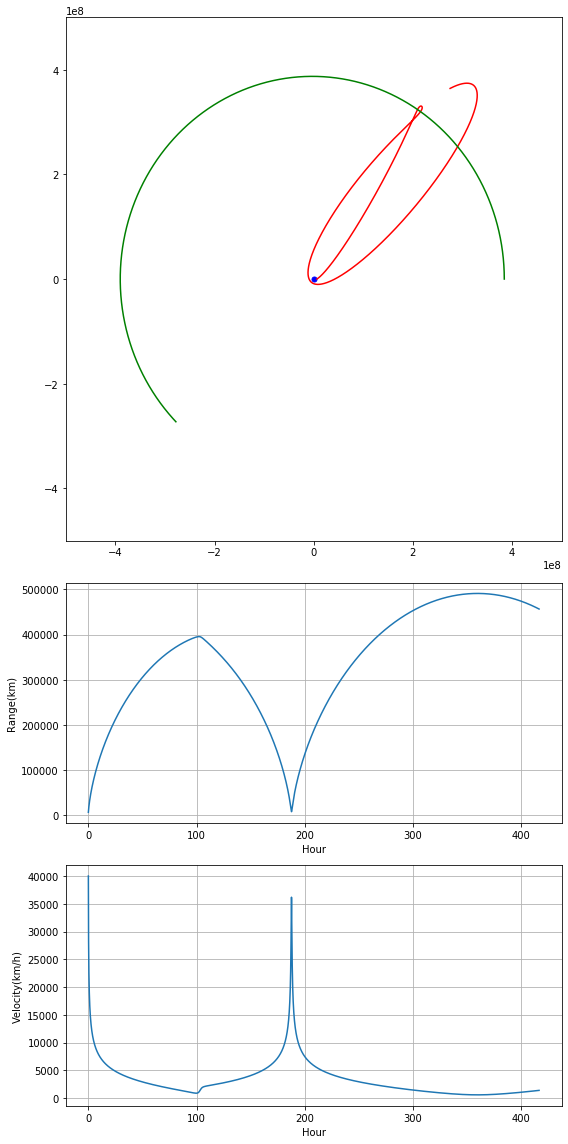

In [10]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm_notebook as tqdm
import glob
import time
from PIL import Image

'''
def rk4(func, t, h, y, *x)
ルンゲ・クッタ法を一回分計算する関数
    引数リスト
    func:導関数
    t：現在時刻を表す変数
    h：刻み幅
    y：出力変数（求めたい値）
    *x:引数の数が可変する事に対応する、その他の必要変数
※この関数では時刻は更新されないため、これとは別に時間更新をする必要があります。
'''
def rk4(func, t, h, y, *x):
    k1=h*func(t, y, *x)
    k2=h*func(t+0.5*h, y+0.5*k1, *x)
    k3=h*func(t+0.5*h, y+0.5*k2, *x) 
    k4=h*func(t+h, y+k3, *x)
    y=y+(k1 + 2*k2 + 2*k3 + k4)/6
    return y

'''
導関数の書き方
def func(t, y, *state):
    func:自分で好きな関数名をつけられます
    t:時刻変数(変数の文字はtで無くても良い) 
    y:出力変数(変数の文字はyで無くても良い)
    *state:その他の必要変数(引数の数は可変可能))
#関数サンプル
def vdot(t, y, *state):
    s1=state[0]
    s2=state[1]
    return t+y+s1+s2
    
'''
#以下粒子の位置と速度を計算するためルンゲクッタソルバに渡す導関数
#速度の微分すなわち加速度の計算
def vdot(t, v, m ,f):
    #print(f/m)
    return f/m

#位置の微分すなわち速度の計算
def xdot(t, x, v):
    #print('v',v)
    return v


class Body:
    #万有引力定数
    G=6.67259e-11
    #刻み幅
    h=1
    
    #コンストラクタ
    def __init__(self, mass, pos ,velocity):
        self.mass=mass
        self.pos=np.array(pos)
        self.velocity=np.array(velocity)
    
    #移動メソッド（状態更新）
    def move(self, member):

        #合力の変数初期化
        sigmaF=np.zeros(2)
        
        #系に存在する天体からの万有引力の合計を求める
        for s in member:
            if s!=self:
                posvec=s.pos - self.pos
                vecnorm=np.linalg.norm(posvec, ord=2)
                unitvec=posvec/vecnorm
                f=unitvec*self.G*s.mass*self.mass/vecnorm**2
                sigmaF+=f

        #ルンゲクッタ シルバを読み出し位置と速度を更新
        vtemp=self.velocity
        postemp=self.pos
        self.velocity=rk4(vdot, 0, self.h, vtemp, self.mass, sigmaF)
        self.pos=rk4(xdot, 0, self.h, postemp, vtemp)

        
def remove_glob(pathname, recursive=True):
    for p in glob.glob(pathname, recursive=recursive):
        if os.path.isfile(p):
            os.remove(p)
        
#メインそれぞれの天体の軌道を計算しファイルに出力する

#出力パスとファイル名
pdirectory='./apollo8_data_{:s}/'.format(time.strftime('%y%m%d_%H%M',time.localtime()))
cdirectory='apollo8_c_{:02d}/'
filename='apollo8_'
try:
    os.mkdir(pdirectory)
except:
    print(pdirectory+' already exist.')


#計算ステップ数
N=1500000

#地球(e)と月(m)の半径(m)
roe=6357e3
rom=1737e3

#地球と月とアポロの質量(kg)
moe=5.972e24
mom=7.348e22
moa=3.784e3

#月の公転半径(m) Moon Revolution Radius
mrr=3.844e8

#月の公転速度(m/s)
vor=1022

###########################
                          #
#アポロの初速と打ち上げ角      #
                          #
###########################
np.random.seed(int(time.time()))

#シミュレーション回数
ETA_NUMBER=1

for cnt in range(ETA_NUMBER):
    Cdirectory=cdirectory.format(cnt)
    try:
        os.mkdir(pdirectory+Cdirectory)
    except:
        print(pdirectory+Cdirectory+' already exist.')
        remove_glob(pdirectory+Cdirectory+'*.png')
    
    #ファイル名
    datafilename=pdirectory+Cdirectory+'flytomoon_data.txt'
    paramfilename=pdirectory+Cdirectory+'flytomoon_param.txt'
    trajimgfilename=pdirectory+Cdirectory+'trajectory.png'
    imgfilename=pdirectory+Cdirectory+'apollo_img'

    #乱数でパラメータを振る場合は以下の２行のコメントを外す
    #vel0=11109.572613308712+20*0.5*(np.random.rand()-0.5)
    #deg=30.30836644414167+10*0.5*(np.random.rand()-0.5)
    
    #固定値でシミュレーションをする場合は以下の２行のコメントを外す
    vel0=11110.701683844512 
    deg=30.193846236174522
    
    angle=deg*np.pi/180      
    print('[{}]Velocity={} Angle={}'.format(cnt, vel0, deg))
    print(pdirectory+Cdirectory)
 

    #天体の生成
    earth=Body(moe, (0, 0), (0, 0))
    moon=Body(mom, (mrr, 0), (0, vor))
    apollo=Body(moa, (roe, 0),(vel0*np.cos(angle),vel0*np.sin(angle)))
    member=(earth, moon, apollo)

    Xm=[]
    Ym=[]
    Xa=[]
    Ya=[]
    Vax=[]
    Vay=[]

    for i in tqdm(range(N)):#1400000 1390000 1400e3
        xm=moon.pos[0]
        ym=moon.pos[1]
        xa=apollo.pos[0]
        ya=apollo.pos[1]
        vax=apollo.velocity[0]
        vay=apollo.velocity[1]
        Xm.append(xm)
        Ym.append(ym)
        Xa.append(xa)
        Ya.append(ya)
        Vax.append(vax)
        Vay.append(vay)

        hitflag=0

        #アポロの月への衝突チェック
        posvec=moon.pos - apollo.pos
        vecnorm=np.linalg.norm(posvec, ord=2)
        if vecnorm<rom:
            print('hit moon')
            hitflag=1
            break
        
        #月の軌道より大幅に遠くにアポロが行った場合は計算を終了
        apollonorm=np.linalg.norm(apollo.pos, ord=2)
        if apollonorm>mrr*1.3:
            break
        
        #アポロの地球への衝突チェック
        posvec=earth.pos - apollo.pos
        vecnorm=np.linalg.norm(posvec, ord=2)
        if vecnorm<roe:
            print('hit earth')
            hitflag=1
            break
            
        #天体の移動！！！
        moon.move(member)
        apollo.move(member)

    data=[]
    length=len(Xm)
    data[len(data):len(data)] = Xm
    data[len(data):len(data)] = Ym
    data[len(data):len(data)] = Xa
    data[len(data):len(data)] = Ya
    data[len(data):len(data)] = Vax
    data[len(data):len(data)] = Vay

    data=np.array(data).reshape(6, length).T
    parameter=np.array((vel0, deg))
    
    np.savetxt(datafilename, data, delimiter=',')
    np.savetxt(paramfilename, parameter, delimiter=',')

    fig = plt.figure(figsize=(8,16), tight_layout=True)
    gs = fig.add_gridspec(4, 1)
    ax1 = fig.add_subplot(gs[0:2, 0])
    ax2 = fig.add_subplot(gs[2, 0])
    ax3 = fig.add_subplot(gs[3, 0])

    #軌跡を表示
    ax1.plot(0, 0, 'o', ms=5, color='blue')
    ax1.plot(Xa, Ya,color='red')
    ax1.plot(Xm, Ym,color='green')
    ax1.set_xlim(-5e8, 5e8)
    ax1.set_ylim(-5e8, 5e8)

    #アポロの地球からの距離の変化を表示
    t=np.arange(len(Xa))
    Xa=np.array(Xa)
    Ya=np.array(Ya)
    apollo_range=np.sqrt(Xa**2+Ya**2)
    ax2.plot(t/3600, apollo_range/1000)
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('Range(km)')
    ax2.grid()

    #アポロの速度の変化を表示
    t=np.arange(len(Xa))
    Vax=np.array(Vax)
    Vay=np.array(Vay)
    apollo_velocity=np.sqrt(Vax**2+Vay**2)
    ax3.plot(t/3600, apollo_velocity/1000*3600)
    ax3.set_xlabel('Hour')
    ax3.set_ylabel('Velocity(km/h)')
    ax3.grid()

    #グラフを画像として保存
    plt.savefig(trajimgfilename)
    plt.show()
    
    # 一枚づつ紙芝居的な画像を生成しGIFアニメ作成の画像を準備する
    #import matplotlib.pyplot as plt
    #import numpy as np
    #from tqdm._tqdm_notebook import tqdm_notebook as tqdm

    output=np.loadtxt(datafilename, delimiter=',')
    counter=0
    time=0
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    
    step=int(10000/Body.h)
    for value in tqdm(output[::step]):
        xm=value[0]
        ym=value[1]
        xa=value[2]
        ya=value[3]
        vax=value[4]
        vay=value[5]
        velvec=np.array((vax, vay))
        velocity=np.linalg.norm(velvec, ord=2)

        # fc = face color, ec = edge color
        e = patches.Circle(xy=(0, 0), radius=roe, fc='b', ec='b')
        m = patches.Circle(xy=(xm, ym), radius=rom, fc='g', ec='g')

        ax.add_patch(e)
        ax.add_patch(m)
        plt.plot(xa,ya,'o', ms=3, color='red')
        #plt.plot(xm,ym,'o', ms=5, color='green')
        #plt.plot(0,0,'o', ms=5, color='blue')
        ax.set_xlim(-5e8, 5e8)
        ax.set_ylim(-5e8, 5e8)
        ax.text(-4.5e8, 4.5e8, 'Apollo Velocity={:5.0f}m/s'.format(velocity),fontsize=20)
        ax.text(-4.5e8, 4.0e8, 'Time={:.0f}h'.format(time*Body.h/3600),fontsize=20)
        plt.savefig(imgfilename+'{:04d}.png'.format(counter))
        plt.cla()
        counter+=1
        time+=step
    plt.close()

    #GIF アニメにする
    files=[]
    images=[]
    files = sorted(glob.glob(imgfilename+'????.png'))  
    images = list(map(lambda file : Image.open(file) , files))
    images[0].save(pdirectory+Cdirectory+'apollo_anim.gif' , save_all = True , append_images = images[1:] , duration = 100 , loop = 0)

